In [2]:
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker 
import datetime as dt 
import matplotlib.dates as mdates

going to set key to date(enforcing datetime type)

In [16]:
all5df = pd.read_csv('sandp500/all_stocks_5yr.csv', parse_dates = True , index_col = 'Date', infer_datetime_format = True)
all5df.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2012-08-13,92.29,92.59,91.74,92.40,2075391.0,MMM
2012-08-14,92.36,92.50,92.01,92.30,1843476.0,MMM
2012-08-15,92.00,92.74,91.94,92.54,1983395.0,MMM
2012-08-16,92.75,93.87,92.21,93.74,3395145.0,MMM
2012-08-17,93.93,94.30,93.59,94.24,3069513.0,MMM


In [17]:
all5df.index

DatetimeIndex(['2012-08-13', '2012-08-14', '2012-08-15', '2012-08-16',
               '2012-08-17', '2012-08-20', '2012-08-21', '2012-08-22',
               '2012-08-23', '2012-08-24',
               ...
               '2017-07-31', '2017-08-01', '2017-08-02', '2017-08-03',
               '2017-08-04', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11'],
              dtype='datetime64[ns]', name=u'Date', length=606801, freq=None)

# dropping nulls....


In [4]:
all5df = all5df.drop(all5df.loc[all5df['Volume'].isnull()].index) #drops rows with a null cell in the Volume column
all5df = all5df.drop(all5df.loc[all5df['Open'].isnull()].index) #drops rows with a null cell in the Open column

### changing figsize

In [6]:
fig_size = plt.rcParams["figure.figsize"] #loads current figure size
fig_size[0] = 15 #sets the X size to 15
fig_size[1] = 8 #sets the Y size to 8
plt.rcParams["figure.figsize"] = fig_size #sets this numbers to the new size

# Creating my unadjusted timeseroies and plotting it. specifications can be set in the first 3 lines.....(you can use ts from now on to do some tsa....[im focusing on close, but note that we dont have adj close])

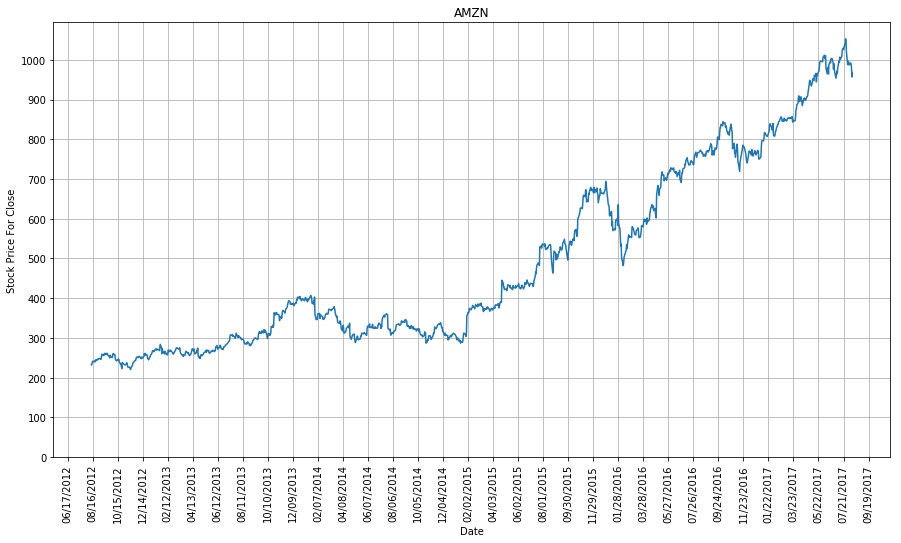

In [26]:
stock = 'AMZN' 
category = 'Close'
xinterval = 60

allstocksingle = all5df[all5df['Name'] == stock] #makes matrix with only the stock info

ts = allstocksingle[category] # this is my time series


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y')) #display the date properly
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=xinterval)) #x axis tick every 60 days
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100)) # sets y axis tick spacing to 100

plt.plot(ts) #plots the x and y
plt.grid(True) #turns on axis grid
plt.ylim(0) #sets the y axis min to zero
plt.xticks(rotation=90,fontsize = 10) #rotates the x axis ticks 90 degress and font size 10
plt.title(stock) #prints the title on the top
plt.ylabel('Stock Price For '+ category) #labels y axis
plt.xlabel('Date') #labels x axis

plt.show()

# clearly is not stationary (but first; formally checking)


In [27]:
ts.head()

Date
2012-08-13    232.44
2012-08-14    233.19
2012-08-15    237.42
2012-08-16    241.55
2012-08-17    241.17
Name: Close, dtype: float64

In [31]:
# from statsmodels.tsa.stattools import acf,pacf # tools to check stationarity/seasonality or some shit
# import statsmodels.tsa.stattools as tsa
# from statsmodels.tsa.arima_model import ARIMA # my model
from statsmodels.tsa.stattools import adfuller #dickey fuller test. hypothesis testing where null hypothesis is that the ts is 
                                                # non stationary. produces test statisitcs and critical values ..

In [35]:
def test_stationarity(timeseries):
    '''
    got this shit from vidya analytics. 
    
    plots rolling statistics(moving averages and std deviation)
    
    displays dickey fuller test statistics and critical values
    '''
    
    #Determing rolling statistics
    
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()
#     rolmean = pd.rolling_mean(timeseries, window=12) # moving average
#     rolstd = pd.rolling_std(timeseries, window=12) # std deviation as time moves forward

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

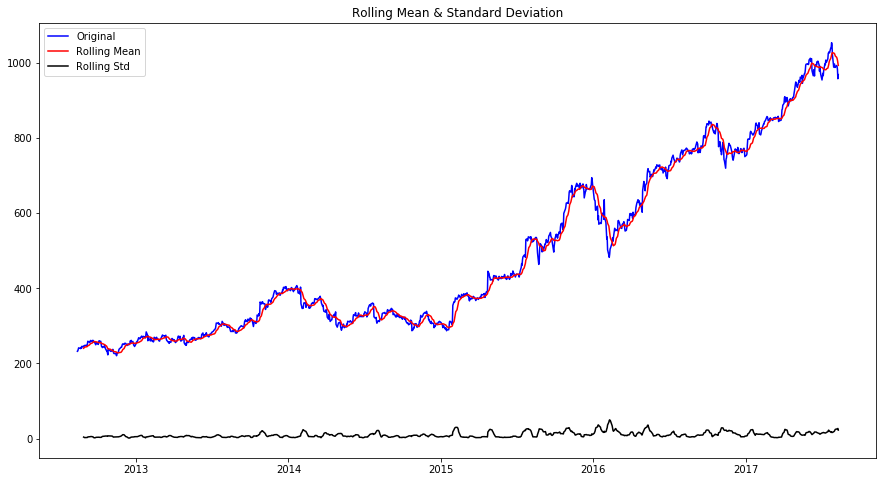

Results of Dickey-Fuller Test:
Test Statistic                    0.436292
p-value                           0.982803
#Lags Used                        0.000000
Number of Observations Used    1257.000000
Critical Value (5%)              -2.863842
Critical Value (1%)              -3.435563
Critical Value (10%)             -2.567996
dtype: float64


In [36]:
test_stationarity(ts)

## test statistic is way more than the critical values so we can reject null hypothesis.. plus to ma is clearly not constant over time... so now we have undeniable proof that our ts is not stationary

# Making ts stationary....

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

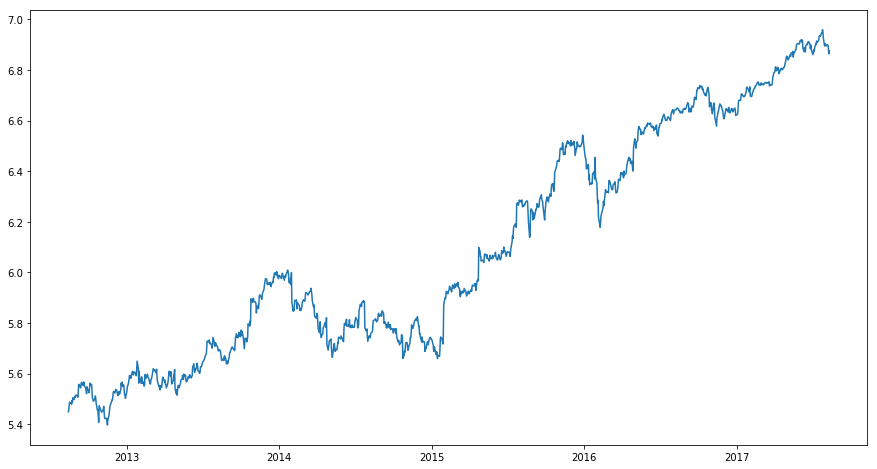

In [53]:
ts_log = np.log(ts)
plt.plot(ts_log)
plt.show()

In [57]:
import statsmodels.tsa.stattools as tsa

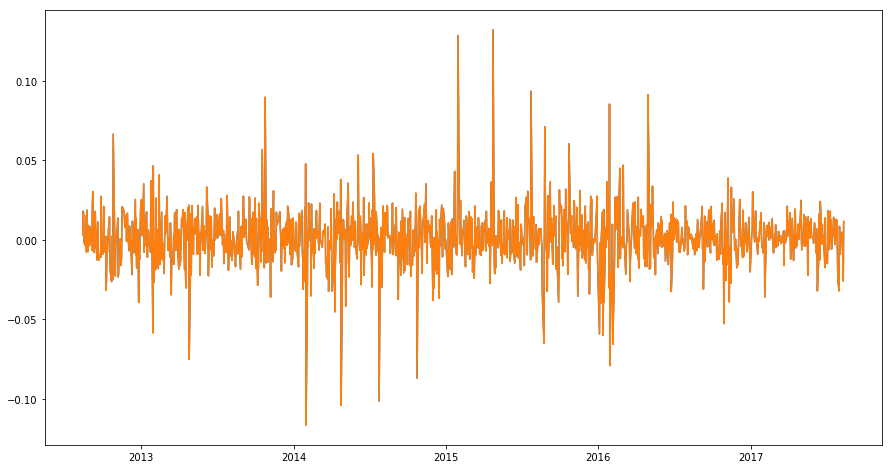

In [52]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
plt.show()

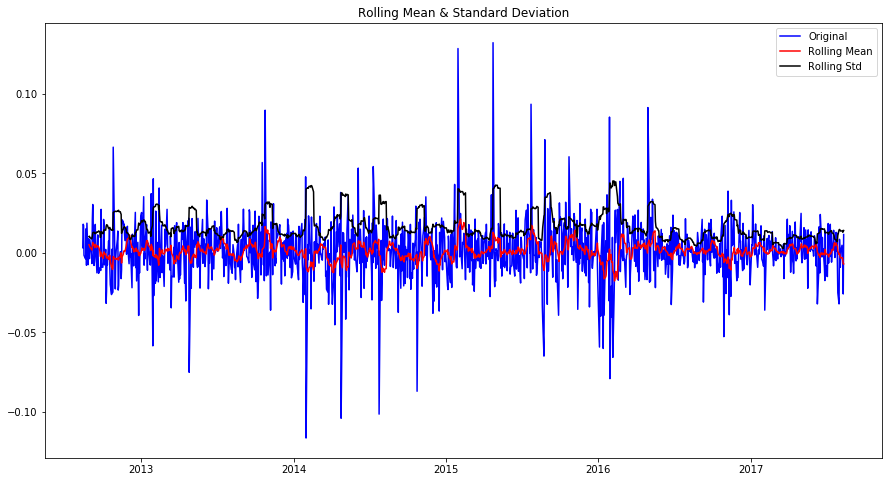

Results of Dickey-Fuller Test:
Test Statistic                  -35.077093
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1256.000000
Critical Value (5%)              -2.863844
Critical Value (1%)              -3.435567
Critical Value (10%)             -2.567997
dtype: float64


In [54]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

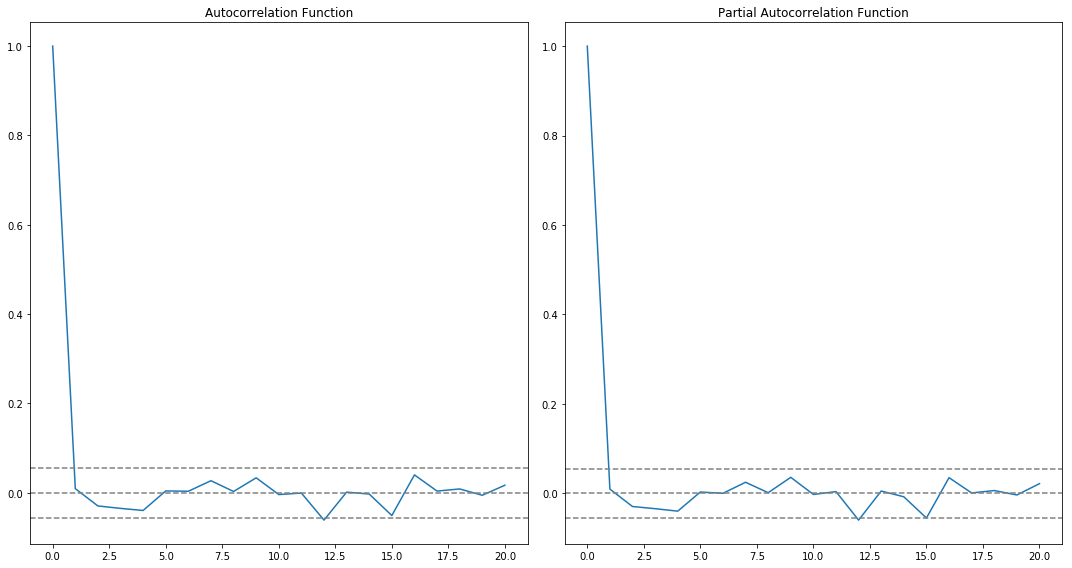

In [56]:
from statsmodels.tsa.stattools import acf,pacf # tools to check stationarity/seasonality or some shit
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

plt.show()

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=1.

q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=1.

In [61]:
from statsmodels.tsa.arima_model import ARIMA # my model

model = ARIMA(ts_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
# plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

plt.show()

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.